## Imports

In [ ]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from transformers import pipeline

## 1. Datasets

### 1. Pavlick and Tetreault Formality Scores (0 -> informal, 1 -> formal)

In [2]:
dataset = load_dataset("osyvokon/pavlick-formality-scores")

train_data = dataset["train"]
test_data = dataset["test"] 

df_train = pd.DataFrame(train_data.to_pandas())  
df_test = pd.DataFrame(test_data.to_pandas())

In [3]:
df_train.head(10)

,domain,avg_score,sentence
0,news,-0.6,Tang was employed at private-equity firm Fried...
1,news,1.0,San Francisco Mayor Gavin Newsom's withdrawal ...
2,answers,-2.8,lol nothing worrying about that.
3,news,0.0,She told Price she wanted to join the Police E...
4,news,1.8,The prime minister is keen to use the autumn p...
5,blog,1.0,Those competencies include mastering fundament...
6,news,0.8,His platform contains plans to fund drainage p...
7,answers,-1.8,"""It's a start."""
8,news,0.6,"""She is not asking for anything over the top, ..."
9,news,0.8,Justice Dinakaran had maintained that he had n...


In [4]:
# data exploration of avg_score
df_train["avg_score"].describe()

count    9274.000000
mean       -0.044080
std         1.349061
min        -3.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: avg_score, dtype: float64

In [5]:
# normalizing the avg_score
df_train["normalized_score"] = (df_train["avg_score"] + 3) / 6
df_test["normalized_score"] = (df_test["avg_score"] + 3) / 6

In [6]:
# concatenate the train and test data, remove the domain column and rename the normalized_score column to formality
data1 = pd.concat([df_train, df_test])
data1 = data1.drop(columns=["domain", "avg_score"])
data1 = data1.rename(columns={"normalized_score": "formality"})
print(len(data1))
data1.head(10)


11274


,sentence,formality
0,Tang was employed at private-equity firm Fried...,0.400000
1,San Francisco Mayor Gavin Newsom's withdrawal ...,0.666667
2,lol nothing worrying about that.,0.033333
3,She told Price she wanted to join the Police E...,0.500000
4,The prime minister is keen to use the autumn p...,0.800000
5,Those competencies include mastering fundament...,0.666667
6,His platform contains plans to fund drainage p...,0.633333
7,"""It's a start.""",0.200000
8,"""She is not asking for anything over the top, ...",0.600000
9,Justice Dinakaran had maintained that he had n...,0.633333


### 2. FAME-MT Dataset (0 -> informal, 1 -> formal)

In [8]:
# read tsv file
formal = pd.read_csv("data/it-en.formal.tsv", sep="\t", on_bad_lines="skip")
formal.columns = ["italian", "english"]
informal = pd.read_csv("data/it-en.informal.tsv", sep="\t", on_bad_lines="skip")
informal.columns = ["italian", "english"]

# drop rows with NaN values
formal = formal.dropna()
informal = informal.dropna()

In [9]:
informal.head(10)

,italian,english
0,"Ma è uscito dal corpo, adesso.",But it's out of the body now.
1,"Ho paura, Elliot.","- I'm scared, Elliot."
2,Bella carta da parati per il desktop scaricare...,Charming desktop wallpapers backgrounds - 1440...
3,- Felice di conoscervi.,- Pleased to meet you.
4,"E sicuramente, sei un cazzone di un ufficiale ...","And sure enough, you've been an official assho..."
5,Ma c'e' ancora un sospetto di omicidio e seque...,But we still have a murder and kidnapping susp...
6,Acquista i biglietti per il Gabba,Grab tickets for the Gabba
7,Lei vive in un villaggio carino dove ci sono u...,She lives in a cute village where there are lo...
8,Quindi il tuo elisir funziona.,So your elixir works.
9,Gokudo Video Recensioni Commenti Maggiori info...,Gokudo Videos Reviews Comments More Info


In [10]:
# concatenate the formal and informal data, add a column formality with values 1 for formal and 0 for informal and shuffle the data
formal["formality"] = 1
informal["formality"] = 0
data2 = pd.concat([formal, informal])
data2 = data2.sample(frac=1, random_state=42).reset_index(drop=True)
data2 = data2.drop(columns=["italian"])
data2 = data2.rename(columns={"english": "sentence"})
print(len(data2))
data2.head(10)

96735


,sentence,formality
0,Listed are cams in category Neu | Show all Cat...,0
1,Weather forecast Arraial d Ajuda this week Sunday,0
2,"Yeah, you know, I'm not one for sentimental crap.",0
3,"For the same reasons, and taking into account ...",1
4,Restaurants West End Village,0
5,"Amazingly enough, this program can eliminate t...",1
6,"Sorry, Mariana called, then Jude needed me, an...",0
7,What Wikipedia say about CContent of green cof...,0
8,Download Underground Tour game...,0
9,Will you...,0


## 2. Models 

In [75]:
pipe = pipeline("text-classification", model="LenDigLearn/formality-classifier-mdeberta-v3-base")


Device set to use mps:0


In [14]:
model_name_mdeberta = "s-nlp/mdeberta-base-formality-ranker"
tokenizer_mdeberta = AutoTokenizer.from_pretrained(model_name_mdeberta)
model_mdeberta = AutoModelForSequenceClassification.from_pretrained(model_name_mdeberta)

model_name_xlmr = "s-nlp/xlmr_formality_classifier"
tokenizer_xlmr = AutoTokenizer.from_pretrained(model_name_xlmr)
model_xlmr = AutoModelForSequenceClassification.from_pretrained(model_name_xlmr)

In [15]:
def get_formality_probability(text, tokenizer, model):
    """
    Given a text, this function tokenizes the input,
    runs inference through the model, and returns the softmax probability
    for the "formal" label (assumed label 1).
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )
    # Run inference; ensure tensors are on the same device as model
    outputs = model(**inputs)
    # Compute softmax over logits to get probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    # Return the probability for label 1 ("formal")
    return probabilities[0][1].item()

## 3. Inference and evaluation

In [40]:
sample_sentences1 = data1["sentence"].tolist()[:500]
sample_sentences2 = data2["sentence"].tolist()[:500]

y_true1 = np.array(data1["formality"][:500].tolist())
y_true2 = np.array(data2["formality"][:500].tolist())

### 3.1 Data 1

#### 3.1.1 mdeberta-v3

In [88]:
results1_mdebertav3 = []
for text in sample_sentences1:
    results1_mdebertav3.append(pipe(text))

In [ ]:
# extract the label 
labels1_mdebertav3 = [result[0]["label"] for result in results1_mdebertav3]

# convert formal to 1 and informal to 0 and neutral to 0.5
labels1_mdebertav3 = [1 if label == "formal" else 0 if label == "informal" else 0.5 for label in labels1_mdebertav3]

In [98]:
# show dataset with sentences, predictions and true labels
df1_mdebertav3 = pd.DataFrame({"sentence": sample_sentences1, "predictions": labels1_mdebertav3, "true_labels": y_true1})
df1_mdebertav3.head(10)

,sentence,predictions,true_labels
0,Tang was employed at private-equity firm Fried...,0.5,0.400000
1,San Francisco Mayor Gavin Newsom's withdrawal ...,1.0,0.666667
2,lol nothing worrying about that.,0.0,0.033333
3,She told Price she wanted to join the Police E...,0.5,0.500000
4,The prime minister is keen to use the autumn p...,1.0,0.800000
5,Those competencies include mastering fundament...,1.0,0.666667
6,His platform contains plans to fund drainage p...,0.5,0.633333
7,"""It's a start.""",0.0,0.200000
8,"""She is not asking for anything over the top, ...",0.5,0.600000
9,Justice Dinakaran had maintained that he had n...,1.0,0.633333


In [100]:
# Compute metrics:
mae = mean_absolute_error(y_true1, labels1_mdebertav3)
mse = mean_squared_error(y_true1, labels1_mdebertav3)
rmse = np.sqrt(mse)
r2 = r2_score(y_true1, labels1_mdebertav3)
pearson_corr = pearsonr(y_true1, labels1_mdebertav3)[0]
spearman_corr = spearmanr(y_true1, labels1_mdebertav3)[0]
print("Continuous Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")

Continuous Evaluation Metrics:
MAE: 0.172
MSE: 0.044
RMSE: 0.209
R2: 0.149
Pearson Correlation: 0.755
Spearman Correlation: 0.744


#### 3.1.2 xmlr

In [31]:
results1_xmlr = []
for sent in sample_sentences1:
    prob_xlmr = get_formality_probability(sent, tokenizer_xlmr, model_xlmr)
    results1_xmlr.append(prob_xlmr)

results1_xmlr = 1 - np.array(results1_xmlr)

##### Binary classification

In [32]:
# make the results and true labels binary
b_results1_xmlr = np.where(results1_xmlr > 0.5, 1, 0)
b_y_true1 = np.where(y_true1 > 0.5, 1, 0)

In [42]:
# show dataset with sentences, predictions and true labels
df_results1_xmlr = pd.DataFrame({"sentence": sample_sentences1, "prediction": results1_xmlr, "true_label": y_true1})
df_results1_xmlr

,sentence,prediction,true_label
0,Tang was employed at private-equity firm Fried...,0.998518,0.400000
1,San Francisco Mayor Gavin Newsom's withdrawal ...,0.998631,0.666667
2,lol nothing worrying about that.,0.002674,0.033333
3,She told Price she wanted to join the Police E...,0.998608,0.500000
4,The prime minister is keen to use the autumn p...,0.998626,0.800000
...,...,...,...
495,At least seven people were killed and several ...,0.998641,0.666667
496,The choice was not an easy one for Robert McCl...,0.998645,0.600000
497,Probably a 10 or 15 percent shade of cyan.,0.105627,0.533333
498,Here is a brief update on major DCF news that ...,0.998646,0.933333


In [43]:
# Compute metrics:
acc = accuracy_score(b_y_true1, b_results1_xmlr)
prec = precision_score(b_y_true1, b_results1_xmlr)
rec = recall_score(b_y_true1, b_results1_xmlr)
f1 = f1_score(b_y_true1, b_results1_xmlr)
cm = confusion_matrix(b_y_true1, b_results1_xmlr)

print("Binary Evaluation Metrics:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("Confusion Matrix:")
print(cm)

Binary Evaluation Metrics:
Accuracy:  0.684
Precision: 0.616
Recall:    0.968
F1 Score:  0.753
Confusion Matrix:
[[101 150]
 [  8 241]]


##### Continuous classification

they don't make a lot of sense because the models are supposed to be confident and output simply formal or informal with strong confidence. instead the dataset is meant to see formality as a continuous variable, as if the sentences have various shades of formality. 

In [ ]:
# Compute metrics:
mae = mean_absolute_error(y_true1, results1_xmlr)
mse = mean_squared_error(y_true1, results1_xmlr)
rmse = np.sqrt(mse)
r2 = r2_score(y_true1, results1_xmlr)
pearson_corr = pearsonr(y_true1, results1_xmlr)[0]
spearman_corr = spearmanr(y_true1, results1_xmlr)[0]
print("Continuous Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")

Continuous Evaluation Metrics:
MAE: 0.370
MSE: 0.173
RMSE: 0.416
R2: -2.364
Pearson Correlation: 0.618
Spearman Correlation: 0.690


#### mdberta

In [ ]:
results1_mdeberta = []
for sent in sample_sentences1:
    prob_mdberta = get_formality_probability(sent, tokenizer_mdeberta, model_mdeberta)
    results1_mdeberta.append(prob_mdberta)

results1_mdeberta = 1 - np.array(results1_mdeberta)

##### Binary classification

In [ ]:
# make the results and true labels binary
b_results1_mdeberta = np.where(results1_mdeberta > 0.15, 1, 0)
b_y_true1 = np.where(y_true1 > 0.5, 1, 0)

In [ ]:
# show dataset with sentences, predictions and true labels
df_results1_mdeberta = pd.DataFrame({"sentence": sample_sentences1, "prediction": results1_mdeberta, "true_label": y_true1})
df_results1_mdeberta

,sentence,prediction,true_label
0,Tang was employed at private-equity firm Fried...,0.001700,0.400000
1,San Francisco Mayor Gavin Newsom's withdrawal ...,0.005246,0.666667
2,lol nothing worrying about that.,0.001454,0.033333
3,She told Price she wanted to join the Police E...,0.002493,0.500000
4,The prime minister is keen to use the autumn p...,0.036147,0.800000
...,...,...,...
495,At least seven people were killed and several ...,0.001860,0.666667
496,The choice was not an easy one for Robert McCl...,0.004888,0.600000
497,Probably a 10 or 15 percent shade of cyan.,0.001822,0.533333
498,Here is a brief update on major DCF news that ...,0.016434,0.933333


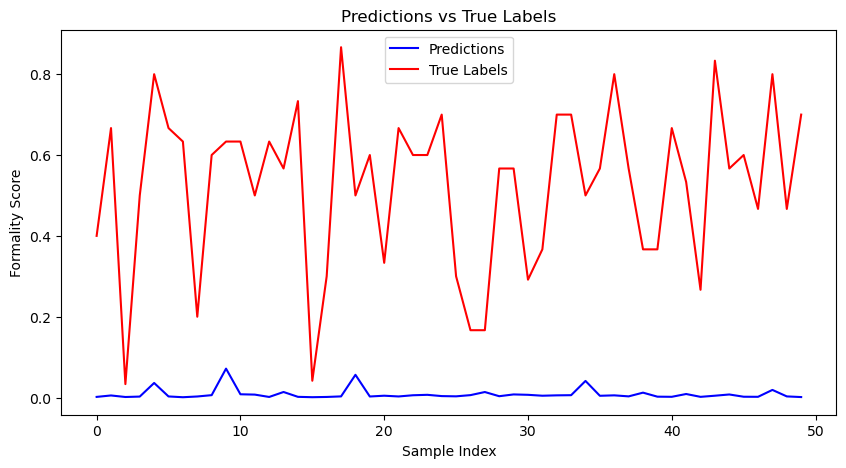

In [ ]:
# plot predictions and true labels
plt.figure(figsize=(10, 5))
plt.plot(df_results1_mdeberta["prediction"][:50], label="Predictions", color="blue")
plt.plot(df_results1_mdeberta["true_label"][:50], label="True Labels", color="red")
plt.title("Predictions vs True Labels")
plt.xlabel("Sample Index")
plt.ylabel("Formality Score")
plt.legend()
plt.show()

In [ ]:
# describe results1_mdeberta
df_results1_mdeberta["prediction"].describe()

count    500.000000
mean       0.016528
std        0.039949
min        0.000717
25%        0.002498
50%        0.004118
75%        0.010632
max        0.378134
Name: prediction, dtype: float64

In [ ]:
# Compute metrics:
acc = accuracy_score(b_y_true1, b_results1_mdeberta)
prec = precision_score(b_y_true1, b_results1_mdeberta)
rec = recall_score(b_y_true1, b_results1_mdeberta)
f1 = f1_score(b_y_true1, b_results1_mdeberta)
cm = confusion_matrix(b_y_true1, b_results1_mdeberta)

print("Binary Evaluation Metrics:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("Confusion Matrix:")
print(cm)

Binary Evaluation Metrics:
Accuracy:  0.492
Precision: 0.273
Recall:    0.012
F1 Score:  0.023
Confusion Matrix:
[[243   8]
 [246   3]]


### 3.2 Data 2

#### 3.2.1 mdeberta-v3

In [101]:
results2_mdebertav3 = []
for text in sample_sentences2:
    results2_mdebertav3.append(pipe(text))

In [113]:
# extract the label 
labels2_mdebertav3 = [result[0]["label"] for result in results2_mdebertav3]

# convert formal to 1 and informal to 0 and neutral to 0.5
labels2_mdebertav3 = [1 if label == "formal" else 0 if label == "informal" else 0.5 for label in labels2_mdebertav3]

In [114]:
# show dataset with sentences, predictions and true labels
df2_mdebertav3 = pd.DataFrame({"sentence": sample_sentences2, "predictions": labels2_mdebertav3, "true_labels": y_true2})
df2_mdebertav3.head(190)

,sentence,predictions,true_labels
0,Listed are cams in category Neu | Show all Cat...,0.5,0
1,Weather forecast Arraial d Ajuda this week Sunday,0.5,0
2,"Yeah, you know, I'm not one for sentimental crap.",0.0,0
3,"For the same reasons, and taking into account ...",1.0,1
4,Restaurants West End Village,0.5,0
...,...,...,...
185,"In encouraging people to sign the petition, Ar...",0.5,1
186,"Mr Ocampo told the BBC that the ICC, after inv...",1.0,1
187,He really is.,0.5,0
188,Copyright The content and work on pages create...,1.0,1


In [115]:
# Compute metrics:
mae = mean_absolute_error(y_true2, labels2_mdebertav3)
mse = mean_squared_error(y_true2, labels2_mdebertav3)
rmse = np.sqrt(mse)
r2 = r2_score(y_true2, labels2_mdebertav3)
pearson_corr = pearsonr(y_true2, labels2_mdebertav3)[0]
spearman_corr = spearmanr(y_true2, labels2_mdebertav3)[0]
print("Continuous Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")

Continuous Evaluation Metrics:
MAE: 0.245
MSE: 0.141
RMSE: 0.376
R2: 0.433
Pearson Correlation: 0.666
Spearman Correlation: 0.666


#### xmlr

In [60]:
results2_xmlr = []
for sent in sample_sentences2:
    prob_xlmr = get_formality_probability(sent, tokenizer_xlmr, model_xlmr)
    results2_xmlr.append(prob_xlmr)

results2_xmlr = 1 - np.array(results2_xmlr)

Binary classification

In [61]:
# make the results and true labels binary
b_results2_xmlr = np.where(results2_xmlr > 0.5, 1, 0)
b_y_true2 = np.where(y_true2 > 0.5, 1, 0)

In [62]:
# show dataset with sentences, predictions and true labels
df_results2_xmlr = pd.DataFrame({"sentence": sample_sentences2, "prediction": results2_xmlr, "true_label": y_true2})
df_results2_xmlr

,sentence,prediction,true_label
0,Listed are cams in category Neu | Show all Cat...,0.055602,0
1,Weather forecast Arraial d Ajuda this week Sunday,0.052648,0
2,"Yeah, you know, I'm not one for sentimental crap.",0.131297,0
3,"For the same reasons, and taking into account ...",0.998615,1
4,Restaurants West End Village,0.194481,0
...,...,...,...
495,"Since our arrival, while traveling in a taxi t...",0.998627,1
496,Error rates are usually very low—1 error in ev...,0.998640,1
497,Member contact information may be provided to ...,0.998604,1
498,"7. Our all products are in ex-work price, Most...",0.013378,0


In [64]:
# Compute metrics:
acc = accuracy_score(b_y_true2, b_results2_xmlr)
prec = precision_score(b_y_true2, b_results2_xmlr)
rec = recall_score(b_y_true2, b_results2_xmlr)
f1 = f1_score(b_y_true2, b_results2_xmlr)
cm = confusion_matrix(b_y_true2, b_results2_xmlr)

print("Binary Evaluation Metrics:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("Confusion Matrix:")
print(cm)

Binary Evaluation Metrics:
Accuracy:  0.786
Precision: 0.713
Recall:    0.989
F1 Score:  0.828
Confusion Matrix:
[[135 104]
 [  3 258]]


continuous classification

In [65]:
# Compute metrics:
mae = mean_absolute_error(y_true2, results2_xmlr)
mse = mean_squared_error(y_true2, results2_xmlr)
rmse = np.sqrt(mse)
r2 = r2_score(y_true2, results2_xmlr)
pearson_corr = pearsonr(y_true2, results2_xmlr)[0]
spearman_corr = spearmanr(y_true2, results2_xmlr)[0]
print("Continuous Evaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")

Continuous Evaluation Metrics:
MAE: 0.220
MSE: 0.183
RMSE: 0.428
R2: 0.266
Pearson Correlation: 0.671
Spearman Correlation: 0.782


#### mdberta

In [70]:
results2_mdeberta = []
for sent in sample_sentences2:
    prob_mdberta = get_formality_probability(sent, tokenizer_mdeberta, model_mdeberta)
    results2_mdeberta.append(prob_mdberta)

results2_mdeberta = 1 - np.array(results2_mdeberta)

Binary classification

In [71]:
# make the results and true labels binary
b_results2_mdeberta = np.where(results2_mdeberta > 0.15, 1, 0)
b_y_true2 = np.where(y_true2 > 0.5, 1, 0)

In [72]:
# show dataset with sentences, predictions and true labels
df_results2_mdeberta = pd.DataFrame({"sentence": sample_sentences2, "prediction": results2_mdeberta, "true_label": y_true2})
df_results2_mdeberta

,sentence,prediction,true_label
0,Listed are cams in category Neu | Show all Cat...,0.002387,0
1,Weather forecast Arraial d Ajuda this week Sunday,0.004036,0
2,"Yeah, you know, I'm not one for sentimental crap.",0.004764,0
3,"For the same reasons, and taking into account ...",0.001738,1
4,Restaurants West End Village,0.004869,0
...,...,...,...
495,"Since our arrival, while traveling in a taxi t...",0.007100,1
496,Error rates are usually very low—1 error in ev...,0.002391,1
497,Member contact information may be provided to ...,0.005283,1
498,"7. Our all products are in ex-work price, Most...",0.003123,0


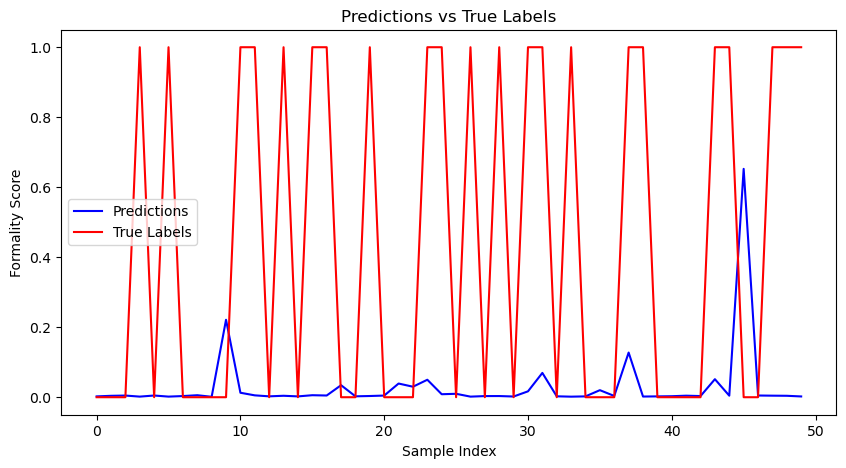

In [73]:
# plot predictions and true labels
plt.figure(figsize=(10, 5))
plt.plot(df_results2_mdeberta["prediction"][:50], label="Predictions", color="blue")
plt.plot(df_results2_mdeberta["true_label"][:50], label="True Labels", color="red")
plt.title("Predictions vs True Labels")
plt.xlabel("Sample Index")
plt.ylabel("Formality Score")
plt.legend()
plt.show()

In [ ]:
# describe results1_mdeberta
df_results1_mdeberta["prediction"].describe()

count    500.000000
mean       0.016528
std        0.039949
min        0.000717
25%        0.002498
50%        0.004118
75%        0.010632
max        0.378134
Name: prediction, dtype: float64

In [ ]:
# Compute metrics:
acc = accuracy_score(b_y_true1, b_results1_mdeberta)
prec = precision_score(b_y_true1, b_results1_mdeberta)
rec = recall_score(b_y_true1, b_results1_mdeberta)
f1 = f1_score(b_y_true1, b_results1_mdeberta)
cm = confusion_matrix(b_y_true1, b_results1_mdeberta)

print("Binary Evaluation Metrics:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")
print("Confusion Matrix:")
print(cm)

Binary Evaluation Metrics:
Accuracy:  0.492
Precision: 0.273
Recall:    0.012
F1 Score:  0.023
Confusion Matrix:
[[243   8]
 [246   3]]
